## Regressão simbólica aplicada ao modelo populacional de Verhulst

In [1]:
# Imports de bibliotecas e funções

from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import verhulst, runge_kutta
from funcoes import Div, Exp

### Solução numérica para o modelo dada pelo método de Runge-Kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 3
K = 1

T, X = runge_kutta(verhulst, T0, X0, TF, H, K)

### Algoritmo genético de Regressão simbólica 

In [3]:
# Constantes relacionadas a busca

NUM_GERACOES = 500
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

pset.addEphemeralConstant("rand103", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)

   	      	                      fitness                      	                  size                 
   	      	---------------------------------------------------	---------------------------------------
gen	nevals	avg        	gen	min    	nevals	std        	avg  	gen	min	nevals	std    
0  	1000  	5.37623e+40	0  	1.52645	1000  	1.20096e+42	3.976	0  	2  	1000  	1.66296
1  	545   	15.4068    	1  	1.52645	545   	16.0865    	3.866	1  	1  	545   	1.65228
2  	528   	1.04083e+15	2  	1.52645	528   	3.28973e+16	3.849	2  	1  	528   	1.73557


c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


3  	478   	inf        	3  	1.36598	478   	nan        	4.12 	3  	1  	478   	1.80211
4  	476   	inf        	4  	1.36598	476   	nan        	4.372	4  	1  	476   	1.72035
5  	516   	20.4891    	5  	1.36598	516   	332.353    	4.818	5  	1  	516   	1.66999
6  	511   	28.1394    	6  	1.36598	511   	516.306    	5.088	6  	1  	511   	1.55957
7  	524   	38343.3    	7  	1.36598	524   	1.21159e+06	5.362	7  	1  	524   	1.59215
8  	471   	19.3061    	8  	1.36598	471   	328.72     	5.471	8  	1  	471   	1.58656
9  	521   	inf        	9  	1.36598	521   	nan        	5.538	9  	1  	521   	1.6663 


C:\JupyterLab\Regressão simbolica\RNAG_Trabalho_Final\funcoes.py:92: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\ANA220~1\AppData\Local\Temp/ipykernel_49868/1863226702.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


10 	514   	inf        	10 	1.36598	514   	nan        	5.447	10 	1  	514   	1.81692
11 	551   	inf        	11 	1.36598	551   	nan        	5.351	11 	1  	551   	1.87345
12 	488   	inf        	12 	1.36598	488   	nan        	5.151	12 	1  	488   	1.89584
13 	503   	inf        	13 	1.36598	503   	nan        	5.057	13 	1  	503   	1.91566
14 	557   	inf        	14 	1.36598	557   	nan        	4.922	14 	1  	557   	1.79497
15 	502   	inf        	15 	1.36598	502   	nan        	5.056	15 	1  	502   	1.9248 
16 	518   	inf        	16 	1.36598	518   	nan        	5.321	16 	1  	518   	2.06494
17 	488   	inf        	17 	1.36598	488   	nan        	5.47 	17 	1  	488   	2.06521
18 	503   	inf        	18 	1.36598	503   	nan        	5.815	18 	1  	503   	2.20199
19 	522   	inf        	19 	1.21106	522   	nan        	6.232	19 	1  	522   	2.39712
20 	496   	inf        	20 	1.21106	496   	nan        	6.617	20 	1  	496   	2.3913 
21 	505   	inf        	21 	1.21106	505   	nan        	6.778	21 	1  	505   	2.42832
22 	

In [11]:
for i in hof.items:
    print(str(i))
    print()

Exp(Exp(Div(t, sub(-1, Div(t, sub(-1, Exp(t)))))))

Exp(Exp(Div(t, sub(-1, Div(t, sub(-1, Exp(1)))))))

Exp(Exp(Div(t, Div(t, sub(add(1, 0), Exp(t))))))

Exp(Exp(Div(t, Div(t, sub(1, Exp(t))))))

Exp(Exp(sub(Div(t, sub(-1, Exp(t))), t)))



### Reportando melhor individuo encontrado 

Exp(Exp(Div(t, sub(-1, Div(t, sub(-1, Exp(t)))))))


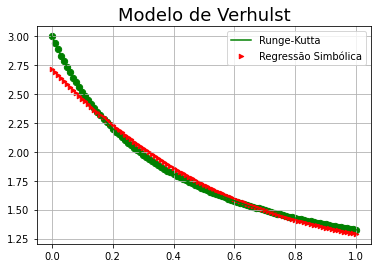

In [12]:
melhor_individuo = str(hof.items[0])
print(melhor_individuo)

func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)


fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Verhulst', size = 18)
ax.scatter(T, X, c = 'g', s = 40)
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r', s = 20)
ax.plot(T, Xexpr, c = 'r')

ax.legend()

ax.grid('--')
#plt.savefig('resultados\Resultado_Verhulst_1.png', dpi = 200)

In [13]:
# transformando as funções em numéricas 

def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand104", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
print("O melhor individuo encontrado: ")
display(sp.expand(func(t)))

O melhor individuo encontrado: 


exp(exp(t/(-t/(-exp(t) - 1) - 1)))